In [1]:
import sys
sys.path.append('../core')
sys.path.append('/packing/code/core/')

import pack_runner
import pack_ga3
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import os
import itertools
import glob
import dill
import importlib
from multiprocess import Process, Queue, cpu_count
import kaggle_support as kgs
importlib.reload(pack_runner)

# Configuration
output_dir = '../../results/many_ga/'
os.makedirs(output_dir + 'full/', exist_ok=True)
os.makedirs(output_dir + 'abbr/', exist_ok=True)

fast_mode = False  # Set to True for quick testing
which_runner = pack_runner.baseline_runner  # Which example runner to use
n_parallel_processes = 2 if kgs.env=='local' else 4
print(f"Will use {n_parallel_processes} parallel processes")

vast
Will use 4 parallel processes


In [2]:
#test
if fast_mode:
    rr = pack_runner.baseline_runner(fast_mode = fast_mode)
    rr.base_ga.ga.ga_base.N_trees_to_do = 40
    rr.seed=1
    rr.run()

In [3]:
# Get git commit ID for tracking
try:
    import git
    repo = git.Repo(search_parent_directories=True)
    git_commit_id = repo.head.object.hexsha
    print(f"Git commit: {git_commit_id[:8]}")
except:
    git_commit_id = 'no_git'
    print("Git not available, using 'no_git' as commit ID")

Git commit: 514cc32f


In [4]:
%load_ext pyinstrument

Detected 1 GPU(s)
Starting parallel execution of 1000 seeds using 4 processes
Staggering process startup by 2 seconds each...

Starting process for seed 6000...
vast
Seed 6000 using GPU 0

=== Starting seed 6000 (Process 22673) ===
{'seed': 6000, 'N_trees_to_do': 156, 'dist_x': 0.75, 'dist_y': 0.5, 'dist_corner': np.float64(0.0), 'reset_check_generations': 150, 'reset_check_generations_ratio': 0.0, 'crossover_weights': 2.0, 'use_new_ref_score': True, 'adapt_moves': 0.0, 'N': 10, 'population_size': 0.5, 'do_jiggle': False}
140474141 0.0 0.0
691002186 0.5 0.0
674283568 0.0 0.0
778397565 0.0 0.0
594074211 0.5 0.0
595550302 0.0 0.0
947670035 0.0 0.0
789642107 0.5 0.0
893918211 0.5 0.0
611914960 0.5 0.0
init CUDA
Detected GPU compute capability: 12.0 (arch=sm_120)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptx

/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


init LAP CUDA
Detected GPU compute capability: 12.0 (arch=sm_120)
GPU max threads per block: 1024
=== Compiling LAP kernels ===
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_120 -cubin /packing/temp/lap_batch_saved.cu -o /packing/temp/lap_batch.cubin
ptxas info    : 0 bytes gmem
ptxas info    : Compiling entry function 'diversity_shortcut_kernel' for 'sm_120'
ptxas info    : Function properties for diversity_shortcut_kernel
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 31 registers, used 1 barriers
ptxas info    : Compile time = 12.794 ms
ptxas info    : Compiling entry function 'compute_costs' for 'sm_120'
ptxas info    : Function properties for compute_costs
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 37 registers, used 0 barriers
ptxas info    : Compile time = 6.280 ms
ptxas info    : Compiling entry function 'auction_

/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


init LAP CUDA
Detected GPU compute capability: 12.0 (arch=sm_120)
GPU max threads per block: 1024
=== Compiling LAP kernels ===
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_120 -cubin /packing/temp/lap_batch_saved.cu -o /packing/temp/lap_batch.cubin
Starting process for seed 6002...
Generation 16: Best costs = [[0.344925, 0.000188]]
ptxas info    : 0 bytes gmem
ptxas info    : Compiling entry function 'diversity_shortcut_kernel' for 'sm_120'
ptxas info    : Function properties for diversity_shortcut_kernel
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 31 registers, used 1 barriers
ptxas info    : Compile time = 13.403 ms
ptxas info    : Compiling entry function 'compute_costs' for 'sm_120'
ptxas info    : Function properties for compute_costs
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 37 registers, used 0 barriers
ptxas

/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


Generation 27: Best costs = [[0.339376, 4e-05]]
Seed 6003 using GPU 0

=== Starting seed 6003 (Process 22951) ===
{'seed': 6003, 'N_trees_to_do': 156, 'dist_x': 0.5, 'dist_y': 0.25, 'dist_corner': np.float64(0.0), 'reset_check_generations': 100, 'reset_check_generations_ratio': 0.0, 'crossover_weights': 2.0, 'use_new_ref_score': True, 'adapt_moves': 0.5, 'N': 10, 'population_size': 1.0, 'do_jiggle': True}
605591245 0.0 0.0
init LAP CUDA
Detected GPU compute capability: 12.0 (arch=sm_120)
GPU max threads per block: 1024
=== Compiling LAP kernels ===
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_120 -cubin /packing/temp/lap_batch_saved.cu -o /packing/temp/lap_batch.cubin
ptxas info    : 0 bytes gmem
ptxas info    : Compiling entry function 'diversity_shortcut_kernel' for 'sm_120'
ptxas info    : Function properties for diversity_shortcut_kernel
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loa

/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


Generation 35: Best costs = [[0.336435, 9.1e-05]]
init LAP CUDA
Detected GPU compute capability: 12.0 (arch=sm_120)
GPU max threads per block: 1024
=== Compiling LAP kernels ===
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_120 -cubin /packing/temp/lap_batch_saved.cu -o /packing/temp/lap_batch.cubin
ptxas info    : 0 bytes gmem
ptxas info    : Compiling entry function 'diversity_shortcut_kernel' for 'sm_120'
ptxas info    : Function properties for diversity_shortcut_kernel
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 31 registers, used 1 barriers
ptxas info    : Compile time = 13.334 ms
ptxas info    : Compiling entry function 'compute_costs' for 'sm_120'
ptxas info    : Function properties for compute_costs
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 37 registers, used 0 barriers
ptxas info    : Compile time = 6.483 ms


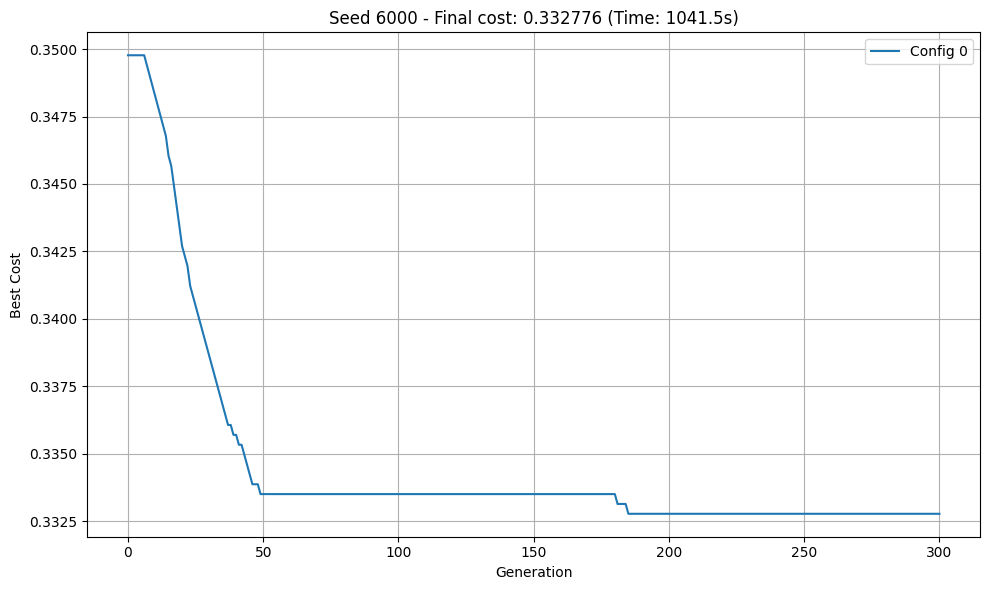

Generation 205: Best costs = [[0.332047, 7.8e-05]]
Starting process for seed 6004...
vast
Seed 6004 using GPU 0

=== Starting seed 6004 (Process 23164) ===
{'seed': 6004, 'N_trees_to_do': 156, 'dist_x': 0.75, 'dist_y': 0.25, 'dist_corner': np.float64(2.121320343559643), 'reset_check_generations': 50, 'reset_check_generations_ratio': 0.1, 'crossover_weights': 2.0, 'use_new_ref_score': True, 'adapt_moves': 0.0, 'N': 16, 'population_size': 0.5, 'do_jiggle': False}
559017449 0.0 0.0
Generation 179: Best costs = [[0.331801, 6.1e-05]]
446212767 0.5 0.0
81685777 0.5 0.0
276174055 0.5 0.0
152003314 0.0 0.0
547364506 0.5 0.0
Generation 206: Best costs = [[0.332047, 7.8e-05]]
Generation 164: Best costs = [[0.331319, 4.4e-05]]
532421242 0.0 0.0
1031117204 0.5 0.0
407079133 0.5 0.0
204847082 0.5 0.0
32635002 0.0 0.0
391971190 0.0 0.0
932053466 0.5 0.0
Generation 180: Best costs = [[0.331801, 6.1e-05]]
130156989 0.0 0.0
127157906 0.0 0.0
Generation 207: Best costs = [[0.332047, 7.8e-05]]
875244863 

/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


Generation 210: Best costs = [[0.332047, 7.7e-05]]
init LAP CUDA
Detected GPU compute capability: 12.0 (arch=sm_120)
GPU max threads per block: 1024
=== Compiling LAP kernels ===
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_120 -cubin /packing/temp/lap_batch_saved.cu -o /packing/temp/lap_batch.cubin
ptxas info    : 0 bytes gmem
ptxas info    : Compiling entry function 'diversity_shortcut_kernel' for 'sm_120'
ptxas info    : Function properties for diversity_shortcut_kernel
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 31 registers, used 1 barriers
ptxas info    : Compile time = 13.333 ms
ptxas info    : Compiling entry function 'compute_costs' for 'sm_120'
ptxas info    : Function properties for compute_costs
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 37 registers, used 0 barriers
ptxas info    : Compile time = 6.474 ms

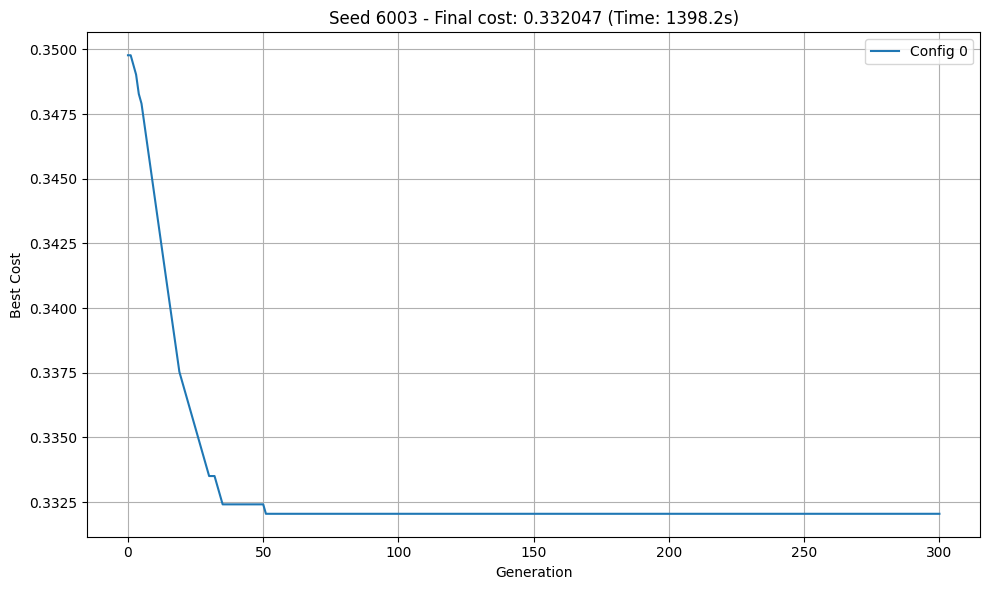

Starting process for seed 6005...
212950024 0.5 0.0
vast
Generation 259: Best costs = [[0.331801, 5.1e-05]]
Seed 6005 using GPU 0

=== Starting seed 6005 (Process 23286) ===
{'seed': 6005, 'N_trees_to_do': 156, 'dist_x': 0.25, 'dist_y': 0.75, 'dist_corner': np.float64(1.4142135623730951), 'reset_check_generations': 50, 'reset_check_generations_ratio': 0.1, 'crossover_weights': 4.0, 'use_new_ref_score': False, 'adapt_moves': 0.0, 'N': 16, 'population_size': 1.0, 'do_jiggle': False}
Generation 92: Best costs = [[0.334237, 5e-05]]
Generation 240: Best costs = [[0.330955, 7.8e-05]]
954724663 0.0 0.0
Generation 260: Best costs = [[0.331801, 5e-05]]
204630241 0.5 0.0
Generation 93: Best costs = [[0.334237, 4.9e-05]]
387997256 0.5 0.0
93104542 0.5 0.0
Generation 241: Best costs = [[0.330955, 7.8e-05]]
947577111 0.5 0.0
201106537 0.0 0.0
Generation 261: Best costs = [[0.331801, 5e-05]]
Generation 94: Best costs = [[0.334237, 4.9e-05]]
961048143 0.0 0.0
374413721 0.5 0.0
43615699 0.5 0.0
394720

/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


init LAP CUDA
Detected GPU compute capability: 12.0 (arch=sm_120)
GPU max threads per block: 1024
=== Compiling LAP kernels ===
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_120 -cubin /packing/temp/lap_batch_saved.cu -o /packing/temp/lap_batch.cubin
Generation 246: Best costs = [[0.330955, 7.8e-05]]
ptxas info    : 0 bytes gmem
ptxas info    : Compiling entry function 'diversity_shortcut_kernel' for 'sm_120'
ptxas info    : Function properties for diversity_shortcut_kernel
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 31 registers, used 1 barriers
ptxas info    : Compile time = 13.551 ms
ptxas info    : Compiling entry function 'compute_costs' for 'sm_120'
ptxas info    : Function properties for compute_costs
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 37 registers, used 0 barriers
ptxas info    : Compile time = 6.571 ms

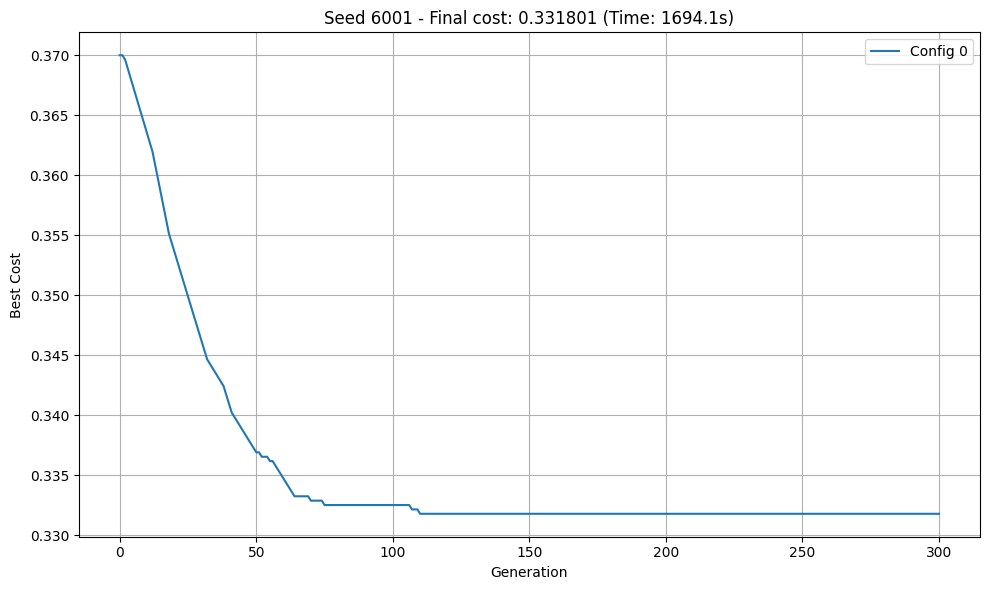

Starting process for seed 6006...
Generation 142: Best costs = [[0.334237, 4.6e-05]]
vast
Generation 27: Best costs = [[0.347278, 0.000143]]
Seed 6006 using GPU 0

=== Starting seed 6006 (Process 23400) ===
{'seed': 6006, 'N_trees_to_do': 156, 'dist_x': 0.75, 'dist_y': 0.75, 'dist_corner': np.float64(0.0), 'reset_check_generations': 150, 'reset_check_generations_ratio': 0.1, 'crossover_weights': 4.0, 'use_new_ref_score': True, 'adapt_moves': 0.25, 'N': 16, 'population_size': 0.5, 'do_jiggle': True}
925388804 0.5 0.0
init CUDA
Detected GPU compute capability: 12.0 (arch=sm_120)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_120 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /packing/temp/pack_cuda_saved.cu -o /packing/temp/pack_cuda_crystal.cub

/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


Generation 147: Best costs = [[0.334237, 4.6e-05]]
init LAP CUDA
Detected GPU compute capability: 12.0 (arch=sm_120)
GPU max threads per block: 1024
=== Compiling LAP kernels ===
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_120 -cubin /packing/temp/lap_batch_saved.cu -o /packing/temp/lap_batch.cubin
ptxas info    : 0 bytes gmem
ptxas info    : Compiling entry function 'diversity_shortcut_kernel' for 'sm_120'
ptxas info    : Function properties for diversity_shortcut_kernel
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 31 registers, used 1 barriers
ptxas info    : Compile time = 13.642 ms
ptxas info    : Compiling entry function 'compute_costs' for 'sm_120'
ptxas info    : Function properties for compute_costs
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 37 registers, used 0 barriers
ptxas info    : Compile time = 6.489 ms

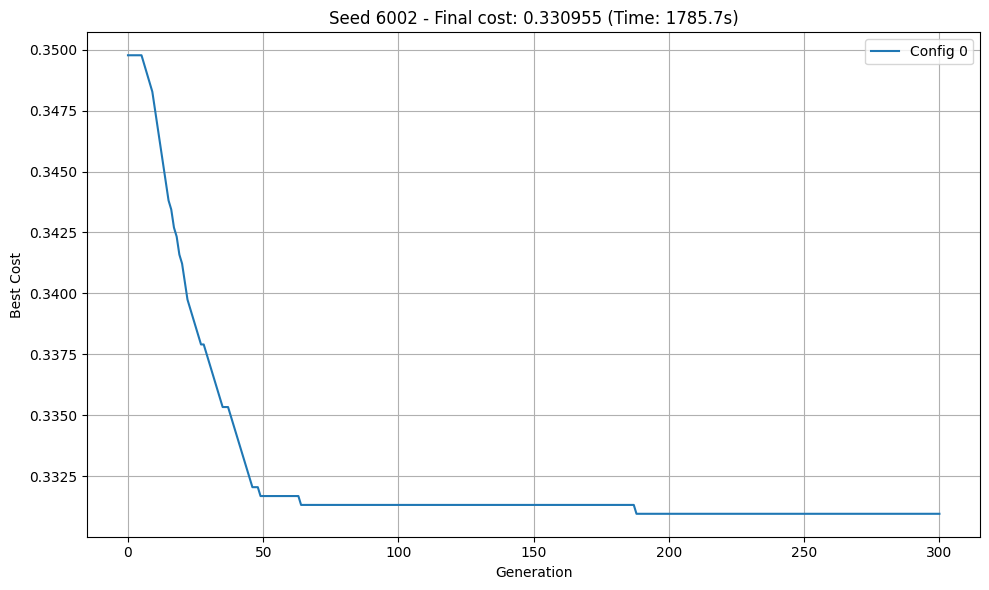

Starting process for seed 6007...
Generation 45: Best costs = [[0.33692, 0.000203]]
vast
Seed 6007 using GPU 0

=== Starting seed 6007 (Process 23651) ===
{'seed': 6007, 'N_trees_to_do': 156, 'dist_x': 0.25, 'dist_y': 0.75, 'dist_corner': np.float64(0.0), 'reset_check_generations': 100, 'reset_check_generations_ratio': 0.1, 'crossover_weights': 2.0, 'use_new_ref_score': False, 'adapt_moves': 0.0, 'N': 16, 'population_size': 0.5, 'do_jiggle': False}
Generation 170: Best costs = [[0.334237, 4.4e-05]]
Generation 27: Best costs = [[0.340482, 6e-05]]
Generation 28: Best costs = [[0.340113, 6.7e-05]]
382937955 0.5 0.0
Generation 171: Best costs = [[0.334237, 4.3e-05]]
842233318 0.0 0.0
Generation 46: Best costs = [[0.336553, 4.6e-05]]
714267973 0.0 0.0
243325458 0.0 0.0
39038366 0.0 0.0
989215860 0.5 0.0
224863 0.5 0.0
Generation 29: Best costs = [[0.339744, 7.2e-05]]
127379481 0.5 0.0
763244831 0.0 0.0
Generation 172: Best costs = [[0.334237, 4.3e-05]]
961939087 0.0 0.0
397001839 0.5 0.0
71

/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


init LAP CUDA
Detected GPU compute capability: 12.0 (arch=sm_120)
GPU max threads per block: 1024
=== Compiling LAP kernels ===
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_120 -cubin /packing/temp/lap_batch_saved.cu -o /packing/temp/lap_batch.cubin
ptxas info    : 0 bytes gmem
ptxas info    : Compiling entry function 'diversity_shortcut_kernel' for 'sm_120'
ptxas info    : Function properties for diversity_shortcut_kernel
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 31 registers, used 1 barriers
ptxas info    : Compile time = 13.121 ms
ptxas info    : Compiling entry function 'compute_costs' for 'sm_120'
ptxas info    : Function properties for compute_costs
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 37 registers, used 0 barriers
ptxas info    : Compile time = 6.392 ms
ptxas info    : Compiling entry function 'auction_

In [ ]:
import kaggle_support as kgs
kgs.profiling = False

def run_single_seed(seed, which_runner, fast_mode, git_commit_id, output_dir, result_queue):
    """Worker function to run a single seed in a separate process"""
    # Import everything needed in this worker process
    import sys
    sys.path.append('../core')
    sys.path.append('/packing/code/core/')
    
    import numpy as np
    import time
    import copy
    import os
    import dill
    
    try:
        # Set CUDA device based on process to avoid conflicts
        # This helps if you have multiple GPUs
        try:
            import cupy as cp
            # Use modulo to cycle through available GPUs
            n_gpus = cp.cuda.runtime.getDeviceCount()
            device_id = seed % n_gpus
            cp.cuda.Device(device_id).use()
            # Small delay to stagger CUDA initialization
            time.sleep(0.5)
            print(f'Seed {seed} using GPU {device_id}')
        except Exception as e:
            print(f'Warning: Could not set CUDA device for seed {seed}: {e}')
        
        print(f'\n=== Starting seed {seed} (Process {os.getpid()}) ===')
        
        r = which_runner(fast_mode=fast_mode)
        r.seed = seed
        r.base_ga.ga.ga_base.N_trees_to_do = 68
        
        # Check if this experiment already exists
        base_filename = f"{r.label}_{r.seed}_{git_commit_id[:8]}"
        if fast_mode:
            base_filename += '_fast'
        
        # Run the experiment
        start_time = time.time()
        r.run()
        elapsed_time = time.time() - start_time
        
        if r.exception is not None:
            print(f"ERROR occurred in seed {seed}: {r.exception[:200]}")
            result_queue.put({'seed': seed, 'success': False, 'error': r.exception[:200]})
            return
        
        # Get best costs for each configuration (tree sizes, etc.)
        # r.best_costs is now shape (n_generations, n_configs) from pack_ga2 structure
        best_costs_final = r.best_costs[-1, :]
        print(f"\nSeed {seed} completed in {elapsed_time:.1f}s")
        print(f"Best final costs: {best_costs_final}")
        print(f"Modifier values: {r.modifier_values}")
        
        # Create score string from average best cost
        avg_cost = np.mean(best_costs_final)
        score_str = f"{avg_cost:.4f}".replace('.', '_')
        
        # Save full version (with populations)
        output_file_full = output_dir + 'full/' + base_filename + '_f.pkl'
        with open(output_file_full, 'wb') as f:
            dill.dump(r, f)
        print(f"Saved full: {output_file_full}")
        
        # Save abbreviated version (without populations to save space)
        r_abbr = copy.deepcopy(r)
        #r_abbr.result_ga.ga.champions = []  # Clear champions to save space
        r_abbr.result_ga.ga.abbreviate()
        output_file_abbr = output_dir + 'abbr/' + base_filename + '_a.pkl'
        with open(output_file_abbr, 'wb') as f:
            dill.dump(r_abbr, f)
        print(f"Saved abbr: {output_file_abbr}")
        
        # Put result data in queue for plotting
        result_queue.put({
            'seed': seed,
            'success': True,
            'label': r.label,
            'best_costs': r.best_costs.copy(),
            'n_configs': r.best_costs.shape[1],  # Number of configurations (tree sizes, etc.)
            'avg_cost': avg_cost,
            'elapsed_time': elapsed_time
        })
        
        print(f"Seed {seed} finished successfully!")
        print(f"{'='*60}")
        
    except Exception as e:
        import traceback
        error_msg = traceback.format_exc()
        print(f"EXCEPTION in seed {seed}:\n{error_msg}")
        result_queue.put({'seed': seed, 'success': False, 'error': str(e)})


# Main parallel execution
n_seeds = 1000 if not fast_mode else 30
result_queue = Queue()
active_processes = []
completed_results = []
seeds_to_run = [a+6000 for a in list(range(n_seeds))]
next_seed_idx = 0

# Limit parallel processes if using GPU (to avoid memory issues)
# You may want to adjust this based on your GPU memory
import cupy as cp
n_gpus = cp.cuda.runtime.getDeviceCount()
print(f"Detected {n_gpus} GPU(s)")

# Adjust parallel processes - too many can overwhelm GPU memory
# Start with 1-2 processes per GPU, adjust based on your GPU memory
max_parallel = n_parallel_processes
print(f"Starting parallel execution of {n_seeds} seeds using {max_parallel} processes")
print(f"Staggering process startup by 2 seconds each...\n")

# Start initial batch of processes with staggered startup
stagger_delay = 30.0  # seconds between each process start
for i in range(min(max_parallel, n_seeds)):
    seed = seeds_to_run[next_seed_idx]
    print(f"Starting process for seed {seed}...")
    p = Process(target=run_single_seed, args=(seed, which_runner, fast_mode, git_commit_id, output_dir, result_queue))
    p.start()
    active_processes.append((p, seed))
    next_seed_idx += 1
    
    # Stagger the startup to avoid CUDA initialization conflicts
    if i < min(max_parallel, n_seeds) - 1:  # Don't sleep after the last one
        time.sleep(stagger_delay)

print(f"\nAll initial processes started. Monitoring for completion...\n")

# Track when we last started a process to stagger new starts
last_process_start_time = time.time()

# Main loop: wait for processes to complete and start new ones
while active_processes or not result_queue.empty():
    # Check for completed results in queue
    while not result_queue.empty():
        result = result_queue.get()
        completed_results.append(result)
        
        if result['success']:
            print(f"\n*** Result received for seed {result['seed']}: avg_cost = {result['avg_cost']:.6f}, time = {result['elapsed_time']:.1f}s ***\n")
            
            # Plot convergence for this seed immediately
            fig, ax = plt.subplots(figsize=(10, 6))
            for i_config in range(result['n_configs']):
                ax.plot(result['best_costs'][:, i_config], label=f'Config {i_config}')
            ax.set_xlabel('Generation')
            ax.set_ylabel('Best Cost')
            ax.set_title(f"Seed {result['seed']} - Final cost: {result['avg_cost']:.6f} (Time: {result['elapsed_time']:.1f}s)")
            ax.legend()
            ax.grid(True)
            plt.tight_layout()
            plt.show()
            
        else:
            print(f"\n*** Seed {result['seed']} failed: {result.get('error', 'Unknown error')} ***\n")
    
    # Check for finished processes and start new ones
    for i in range(len(active_processes) - 1, -1, -1):
        p, seed = active_processes[i]
        if not p.is_alive():
            p.join()
            active_processes.pop(i)
            
            # Start a new process if there are more seeds to run
            if next_seed_idx < n_seeds:
                new_seed = seeds_to_run[next_seed_idx]
                
                # Stagger new process starts to avoid CUDA conflicts
                time_since_last_start = time.time() - last_process_start_time
                if time_since_last_start < stagger_delay:
                    sleep_time = stagger_delay - time_since_last_start
                    print(f"Waiting {sleep_time:.1f}s before starting seed {new_seed}...")
                    time.sleep(sleep_time)
                
                print(f"Starting process for seed {new_seed}...")
                new_p = Process(target=run_single_seed, args=(new_seed, which_runner, fast_mode, git_commit_id, output_dir, result_queue))
                new_p.start()
                active_processes.append((new_p, new_seed))
                last_process_start_time = time.time()
                next_seed_idx += 1
    
    # Small sleep to avoid busy waiting
    time.sleep(0.1)

print(f"\n{'='*80}")
print(f"All {n_seeds} seeds completed!")
print(f"Successful runs: {sum(1 for r in completed_results if r['success'])}")
print(f"Failed runs: {sum(1 for r in completed_results if not r['success'])}")

# Create summary plots for all successful runs
successful_results = [r for r in completed_results if r['success']]
if successful_results:
    print(f"\nCreating summary plots for {len(successful_results)} successful runs...")
    
    # Plot all convergence curves overlaid
    fig, ax = plt.subplots(figsize=(12, 8))
    for result in successful_results:
        for i_config in range(result['n_configs']):
            ax.plot(result['best_costs'][:, i_config], alpha=0.3, linewidth=0.5, color='blue')
    
    ax.set_xlabel('Generation')
    ax.set_ylabel('Best Cost')
    ax.set_title(f'GA Convergence - All {len(successful_results)} Runs (Overlaid)')
    ax.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Plot distribution of final costs
    final_costs = [r['avg_cost'] for r in successful_results]
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(final_costs, bins=30, edgecolor='black', alpha=0.7)
    ax.axvline(np.mean(final_costs), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(final_costs):.6f}')
    ax.axvline(np.min(final_costs), color='green', linestyle='--', linewidth=2, label=f'Best: {np.min(final_costs):.6f}')
    ax.set_xlabel('Average Final Cost')
    ax.set_ylabel('Count')
    ax.set_title(f'Distribution of Final Costs ({len(successful_results)} runs)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\nFinal Statistics:")
    print(f"  Best cost:  {np.min(final_costs):.6f}")
    print(f"  Worst cost: {np.max(final_costs):.6f}")
    print(f"  Mean cost:  {np.mean(final_costs):.6f}")
    print(f"  Std cost:   {np.std(final_costs):.6f}")
    print(f"  Median cost: {np.median(final_costs):.6f}")


In [ ]:
# Optional: Load and analyze results
results_files = sorted(glob.glob(output_dir + 'abbr/*.pkl'))
print(f"Found {len(results_files)} result files")

if len(results_files) > 0:
    # Load all results
    results = []
    for f in results_files:
        with open(f, 'rb') as fp:
            results.append(dill.load(fp))
    
    # Extract hyperparameters and final costs
    hyperparams = []
    final_costs = []
    
    for r in results:
        if r.exception is None and r.best_costs is not None:
            hyperparams.append(r.modifier_values)
            # r.best_costs is shape (n_generations, n_configs)
            # Average across all configs for overall score
            final_costs.append(np.mean(r.best_costs[-1, :]))
    
    print(f"\nSuccessfully completed runs: {len(final_costs)}")
    if len(final_costs) > 0:
        print(f"Best average cost: {np.min(final_costs):.6f}")
        print(f"Worst average cost: {np.max(final_costs):.6f}")
        print(f"Mean average cost: {np.mean(final_costs):.6f}")
        print(f"Std average cost: {np.std(final_costs):.6f}")
        
        # Plot distribution of final costs
        plt.figure(figsize=(8, 5))
        plt.hist(final_costs, bins=20, edgecolor='black')
        plt.xlabel('Average Final Cost')
        plt.ylabel('Count')
        plt.title('Distribution of Final Costs Across Hyperparameter Settings')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
